In [6]:
# import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import joblib


In [7]:
#Load data & quick EDA
df = pd.read_csv('Titanic-Dataset.csv')   
df.head()
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
#Feature engineering (simple, effective features)

# create Title from Name
df['Title'] = df['Name'].str.extract(r',\s*([^.]*)\.', expand=False).str.strip()
# group rare titles
rare_titles = df['Title'].value_counts()[lambda x: x < 10].index
df['Title'] = df['Title'].replace(rare_titles, 'Rare')

# family size
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# drop columns that are not useful or too sparse
df = df.drop(columns=['PassengerId','Name','Ticket','Cabin'])


In [12]:
#Train-test split
X = df.drop(columns='Survived')
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [16]:
#Preprocessing pipeline
# numerical and categorical columns
num_cols = ['Age','Fare','FamilySize','SibSp','Parch','Pclass']
cat_cols = ['Sex','Embarked','Title']

# numeric pipeline: impute median, scale
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# categorical pipeline: impute most frequent, one-hot encode
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))

])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


In [18]:
#Train a baseline model (Logistic Regression)
pipe_lr = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

pipe_lr.fit(X_train, y_train)

# predictions
y_pred = pipe_lr.predict(X_test)


In [20]:
#Evaluate model (common metrics)
def print_eval(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

print_eval(y_test, y_pred)

# ROC AUC
y_proba = pipe_lr.predict_proba(X_test)[:,1]
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Accuracy: 0.8379888268156425
Precision: 0.8225806451612904
Recall: 0.7391304347826086
F1 Score: 0.7786259541984732

Confusion Matrix:
 [[99 11]
 [18 51]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87       110
           1       0.82      0.74      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179

ROC AUC: 0.8783926218708827


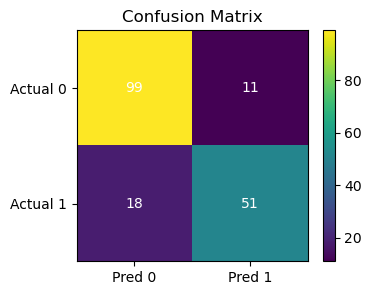

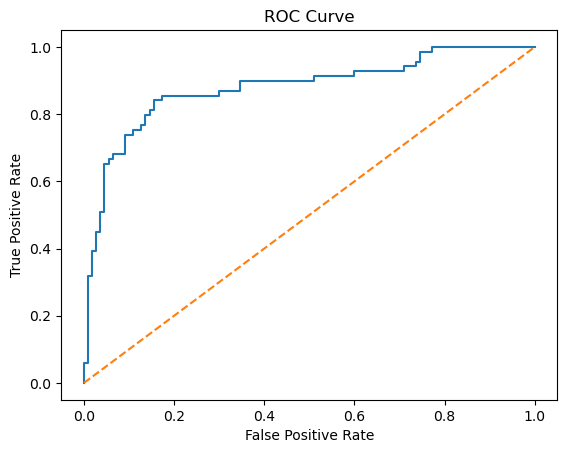

In [22]:
#Visualizations (confusion matrix, ROC, precision-recall)
# Confusion matrix heatmap (matplotlib only)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ['Pred 0','Pred 1'])
plt.yticks([0,1], ['Actual 0','Actual 1'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='white')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


In [24]:
#Cross-validation (robustness check)
cv_scores = cross_val_score(pipe_lr, X, y, cv=5, scoring='accuracy')
print("5-fold CV accuracy:", cv_scores.mean(), "+/-", cv_scores.std())


5-fold CV accuracy: 0.8260247316552632 +/- 0.023389826242425246


In [26]:
#Try a stronger model (Random Forest) and compare
pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)

print("Random Forest evaluation:")
print_eval(y_test, y_pred_rf)
print("ROC AUC (RF):", roc_auc_score(y_test, pipe_rf.predict_proba(X_test)[:,1]))


Random Forest evaluation:
Accuracy: 0.8212290502793296
Precision: 0.7846153846153846
Recall: 0.7391304347826086
F1 Score: 0.7611940298507462

Confusion Matrix:
 [[96 14]
 [18 51]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86       110
           1       0.78      0.74      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

ROC AUC (RF): 0.8299077733860344


In [28]:
#Hyperparameter tuning example (GridSearchCV)
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 5, 10]
}

gs = GridSearchCV(
    pipe_rf, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1
)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV score:", gs.best_score_)

best_rf = gs.best_estimator_
y_pred_best = best_rf.predict(X_test)
print_eval(y_test, y_pred_best)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params: {'clf__max_depth': 5, 'clf__n_estimators': 100}
Best CV score: 0.7613538094298784
Accuracy: 0.8324022346368715
Precision: 0.8095238095238095
Recall: 0.7391304347826086
F1 Score: 0.7727272727272727

Confusion Matrix:
 [[98 12]
 [18 51]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



In [30]:
#Feature importance (for tree-based)
# get feature names after preprocessing
ohe_cols = list(gs.best_estimator_.named_steps['pre'].transformers_[1][1]
                .named_steps['ohe'].get_feature_names_out(cat_cols))
feature_names = num_cols + ohe_cols

importances = best_rf.named_steps['clf'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_imp.head(10))


Sex_male      0.220829
Title_Mr      0.156358
Sex_female    0.129331
Fare          0.108486
Pclass        0.102488
Age           0.065943
FamilySize    0.057436
Title_Miss    0.033708
Title_Mrs     0.032790
SibSp         0.029702
dtype: float64


In [32]:
joblib.dump(best_rf, 'titanic_model_rf.joblib')


['titanic_model_rf.joblib']